In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090a_hw4.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science: 
## Homework 4: Classification: Predicting College Admissions

**Harvard University**<br/>
**Fall 2024**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai

<hr style="height:2.4pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

<div style = "background: lightgreen; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should include labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with slighlty longer output. Avoid excessively long output.
- Feel free to add additional code or markdown cells as needed.
- Don't forget to include a written response when one is requested by a question prompt.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>

### Import Libraries

In [3]:
# RUN THIS CELL
import itertools
import math
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

In [4]:
# For calculating total notebook runtime
notebook_start = time.time()

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Data exploration using train and basic models**](#part1)

- [**Question 2: Interpretable modeling**](#part2)

- [**Question 3: Harvard and Yale?**](#part3)

- [**Question 4: Building predictive models for admitted**](#part4)

- [**Question 5: Evaluating results**](#part5)

- [**Question 6: BONUS!**](#part6)

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)

### Predicting admissions into elite universities

In this problem set we will model the chances of high school students being accepted into two different elite undergraduate colleges: Harvard and Yale.

The data are provided in the file `data/college_admissions.csv` and were scraped in 2022 from [collegedata.com](https://www.collegedata.com/) (where applicants volunteer to share their information).  Each observation corresponds to an applicant to one of the two different colleges (note: the same applicant may show up in two rows: once for each college).  The main response is the `"admitted"` variable (1 = admitted, 0 = denied), and there are are several predictors to consider:

- **id**: a unique identifier for the applicant 
- **test_score**: a standardized measurement of the applicant's highest ACT or SAT combined score (2400 is the maximum)
- **ap**: the number of AP tests taken
- **avg_ap**: the average score on the AP tests taken (0 if no tests were taken)
- **sat_subjects**: the number of SAT subject tests taken
- **gpa**: the unweighted GPA of the applicant (max of 4.0)
- **female**:  a binary indicator for gender: 1 = female, 0 = otherwise
- **minority**: a binary indicator for under-represented minority: 1 = minority, 0 = otherwise 
- **international**: a binary indicator for international status: 1 = international, 0 = United States
- **sports**: a binary indicator for High School All-American: 1 = all-American athlete, 0 = otherwise
- **harvard**: a categorical variable for school applied to: 1 = Harvard, 0 = Yale
- **early_app**: a binary indicator for application type: 1 = early action, 0 = regular
- **alumni**:  a binary indicator for parents' alumni status of school: 1 = a parent is an alumnus, 0 = otherwise
- **program**: the program applied to by the student with many choices (we will not use this as a predictor)
- **add_info**: additional (optional) info provided by applicant (we will not use this as a predictor)

**The main set of 12 predictors is:**

```python
[
    "test_score", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]
```

Please note, you may need to modify this list when fitting different models.


**IMPORTANT NOTES:**

- Unless stated otherwise, all logistic regression models should be unregularized (use `penalty=None`) and include the intercept (which is the default in `sklearn`).


- When printing your output (e.g. coefficients, accuracy scores, etc.), DO NOT just print numbers without context. Please be certain provide clarifying labels for all printed numbers and limit the number of digits showing after decimals to a reasonable length (e.g. 4 decimal points for coefficients and accuracy scores).


- Also be sure to practice good data science principles: always use train to do analysis and never touch the test set until the very end.

---

<a id="part1"></a>

## <div class='exercise'>Question 1: Data exploration using train and basic models</div>

[Return to contents](#contents)

The first step is to split the observations into an approximate 80-20 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). It also prints the dataset's shape before splitting and after splitting. 

**IMPORTANT:** While an argument could be made to scale our predictors here, please **DO NOT** do so **UNTIL** it is requested of you in **[Question 4.1](#part4)**.


In [5]:
#############################
## DO NOT MODIFY THIS CODE ##
#############################
np.random.seed(121)

college = pd.read_csv("data/college_admissions.csv")

college_train, college_test = train_test_split(
    college,
    test_size=0.2,
    random_state=121,
    shuffle=True,
    stratify=college["admitted"],
)

print(college.shape)
print(college_train.shape, college_test.shape)
display(college_train.head())
college_train.info()

# Separate predictors from response
X_train, y_train = college_train.drop(columns=["admitted"]), college_train["admitted"]
X_test, y_test = college_test.drop(columns=["admitted"]), college_test["admitted"]

(1871, 16)
(1496, 16) (375, 16)


,id,admitted,test_score,ap,avg_ap,sat_subjects,gpa,female,minority,international,sports,early_app,alumni,program,add_info,harvard
192,NYFN0GE0KK,1,2310,7,5.000,5,3.98,0,0,0,0,0,0,Economics,Activities Activity Position Honors Grade Levels Approximate Time When Participated Participate ...,1
652,50FWDZ3MBF,1,2010,3,4.333,3,3.75,1,1,0,0,0,0,History Political Science,Drama Club Co founder of a Community Outreach Organization called Los Amigos volunteered helped ...,1
593,KYYHQRHBV9,0,2080,5,4.200,2,3.85,0,0,0,0,0,0,Biology Pre Med,moderate a few sports and clubs and a part time jobfamily circumstances positive,1
331,JQ8O4AV4VM,0,2250,0,0.000,2,4.00,0,0,0,0,0,0,Physics,NaN,1
1117,SJUQZVBA7K,0,2230,4,4.000,5,3.96,1,0,0,0,1,0,Chemistry Chemical Engineering,MUN Advisor 12 10 National Honors Society 12 10 California Scholarship Federation 12 9 Book Club...,0


<class 'pandas.core.frame.DataFrame'>
Index: 1496 entries, 192 to 1296
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1496 non-null   object 
 1   admitted       1496 non-null   int64  
 2   test_score     1496 non-null   int64  
 3   ap             1496 non-null   int64  
 4   avg_ap         1496 non-null   float64
 5   sat_subjects   1496 non-null   int64  
 6   gpa            1496 non-null   float64
 7   female         1496 non-null   int64  
 8   minority       1496 non-null   int64  
 9   international  1496 non-null   int64  
 10  sports         1496 non-null   int64  
 11  early_app      1496 non-null   int64  
 12  alumni         1496 non-null   int64  
 13  program        1298 non-null   object 
 14  add_info       949 non-null    object 
 15  harvard        1496 non-null   int64  
dtypes: float64(2), int64(11), object(3)
memory usage: 198.7+ KB


<div class='exercise-r'>

**Q1.1** Consider a baseline, "naive" model that predicts that *ALL* applicants belong to the same class. This class prediction is *not* determined by an applicant's feature values, but rather by the proportion of observations in the training data belonging to each class.

Calculate the accuracy of this naive model on the training data and store it in `naive_train_acc`.
    
**NOTE:** For this assignment, use the convention that accuracies range from 0 to 1 (to be consistant with sklearn).
    
</div>

In [6]:

from sklearn.dummy import DummyClassifier

# Create a dummy  classifier that always predicts the most frequent class, predict and create accuracy score

naive_classifier = DummyClassifier(strategy='most_frequent')
naive_classifier.fit(X_train, y_train)
y_pred = naive_classifier.predict(X_train)
naive_train_acc = accuracy_score(y_train, y_pred)



In [7]:
print("Naive Classification Model Based on Training Proportions")
print(f"\tTrain Accuracy: {naive_train_acc:.4f}")

Naive Classification Model Based on Training Proportions
	Train Accuracy: 0.7299


In [8]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q1.2** Let's investigate how each of our 12 predictors is associated with whether or not an applicant is admitted into the college to which they applied (`admitted`). To this end, create a separate **visual** for each of our predictors to investigate their relationship with college admissions. **Suggestion:** Place these 12 visuals in a grid of subplots with 3 columns and 4 rows.

</div>

In [9]:

# List of predictor variables
x_predictors = ["test_score", "ap", "avg_ap", "sat_subjects", "gpa", "female", 
              "minority", "international", "sports", "early_app", "alumni", "harvard"]

#create dataframe consists of predictors and response and show example

df1_train = pd.concat([y_train,X_train[x_predictors]],axis=1)

df1_train.head()


,admitted,test_score,ap,avg_ap,sat_subjects,gpa,female,minority,international,sports,early_app,alumni,harvard
192,1,2310,7,5.000,5,3.98,0,0,0,0,0,0,1
652,1,2010,3,4.333,3,3.75,1,1,0,0,0,0,1
593,0,2080,5,4.200,2,3.85,0,0,0,0,0,0,1
331,0,2250,0,0.000,2,4.00,0,0,0,0,0,0,1
1117,0,2230,4,4.000,5,3.96,1,0,0,0,1,0,0


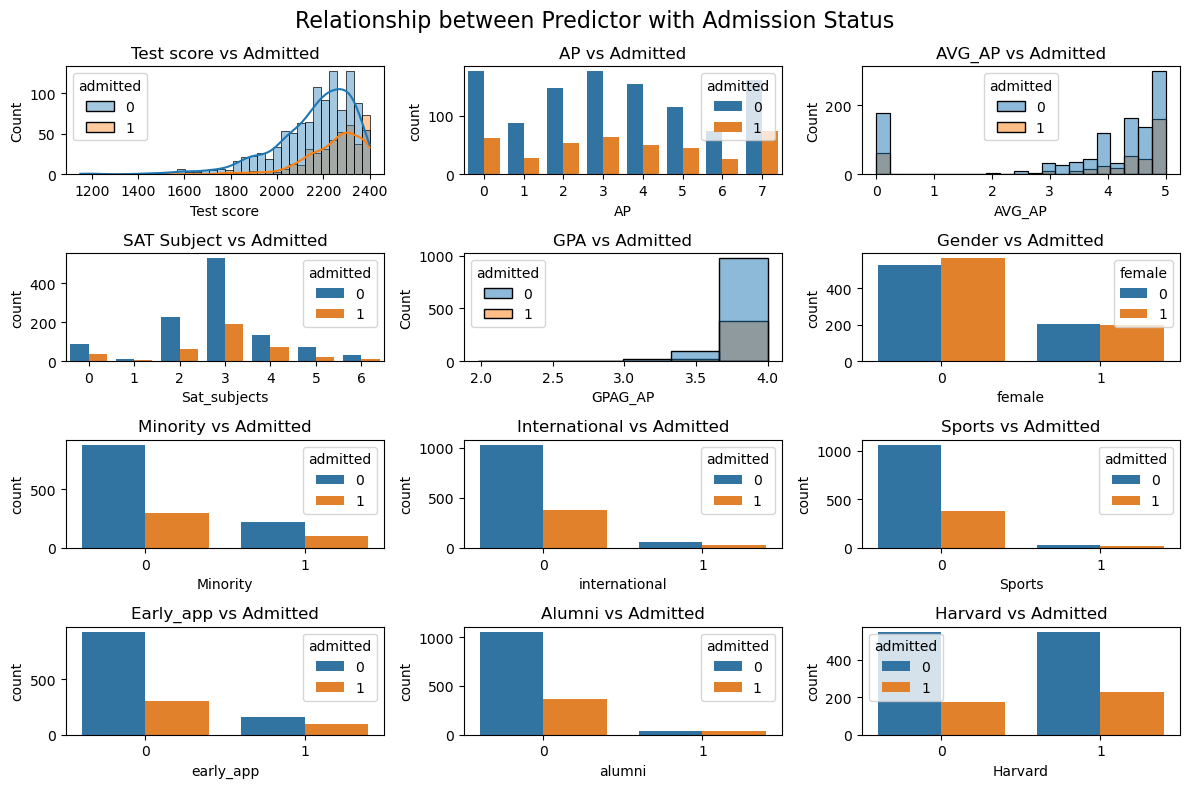

In [10]:
# Plotting

# Set up a grid of subplots and plot each predictor vs Admitted
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8))
fig.suptitle("Relationship between Predictor with Admission Status", fontsize=16)
axes = axes.ravel() 

#Test score vs Admitted
sns.histplot(data=df1_train, x='test_score', hue='admitted', ax=axes[0],kde=True,alpha=0.4)
axes[0].set_xlabel('Test score')
axes[0].set_title('Test score vs Admitted')


#ap vs Admitted
sns.countplot(data=df1_train, x='ap', hue='admitted', ax=axes[1])
axes[1].set_xlabel('AP')
axes[1].set_title('AP vs Admitted')

#avg_ap vs Admitted
sns.histplot(data=df1_train, x='avg_ap', hue='admitted', ax=axes[2])
axes[2].set_xlabel('AVG_AP')
axes[2].set_title('AVG_AP vs Admitted')

#sat_subjects vs Admitted
sns.countplot(data=df1_train, x='sat_subjects', hue='admitted', ax=axes[3])
axes[3].set_xlabel('Sat_subjects')
axes[3].set_title('SAT Subject vs Admitted')

#gpa vs Admitted
sns.histplot(data=df1_train, x='gpa', hue='admitted', ax=axes[4],bins =6)
axes[4].set_xlabel('GPAG_AP')
axes[4].set_title('GPA vs Admitted')

#female vs Admitted
sns.countplot(data=df1_train, x='admitted', hue='female', ax=axes[5])
axes[5].set_xlabel('female')
axes[5].set_title('Gender vs Admitted')

#Minority vs Admitted
sns.countplot(data=df1_train, x='minority', hue='admitted', ax=axes[6])
axes[6].set_xlabel('Minority')
axes[6].set_title('Minority vs Admitted')

#international vs Admitted
sns.countplot(data=df1_train, x='international', hue='admitted', ax=axes[7])
axes[7].set_xlabel('international')
axes[7].set_title('International vs Admitted')

#Sports vs Admitted
sns.countplot(data=df1_train, x='sports', hue='admitted', ax=axes[8])
axes[8].set_xlabel('Sports')
axes[8].set_title('Sports vs Admitted')

#early_app vs Admitted
sns.countplot(data=df1_train, x='early_app', hue='admitted', ax=axes[9])
axes[9].set_xlabel('early_app')
axes[9].set_title('Early_app vs Admitted')

#Alumni vs Admitted
sns.countplot(data=df1_train, x='alumni', hue='admitted', ax=axes[10])
axes[10].set_xlabel('alumni')
axes[10].set_title('Alumni vs Admitted')

#harvard vs Admitted
sns.countplot(data=df1_train, x='harvard', hue='admitted', ax=axes[11])
axes[11].set_xlabel('Harvard')
axes[11].set_title('Harvard vs Admitted')

# Adjust layout
plt.tight_layout()
plt.show()

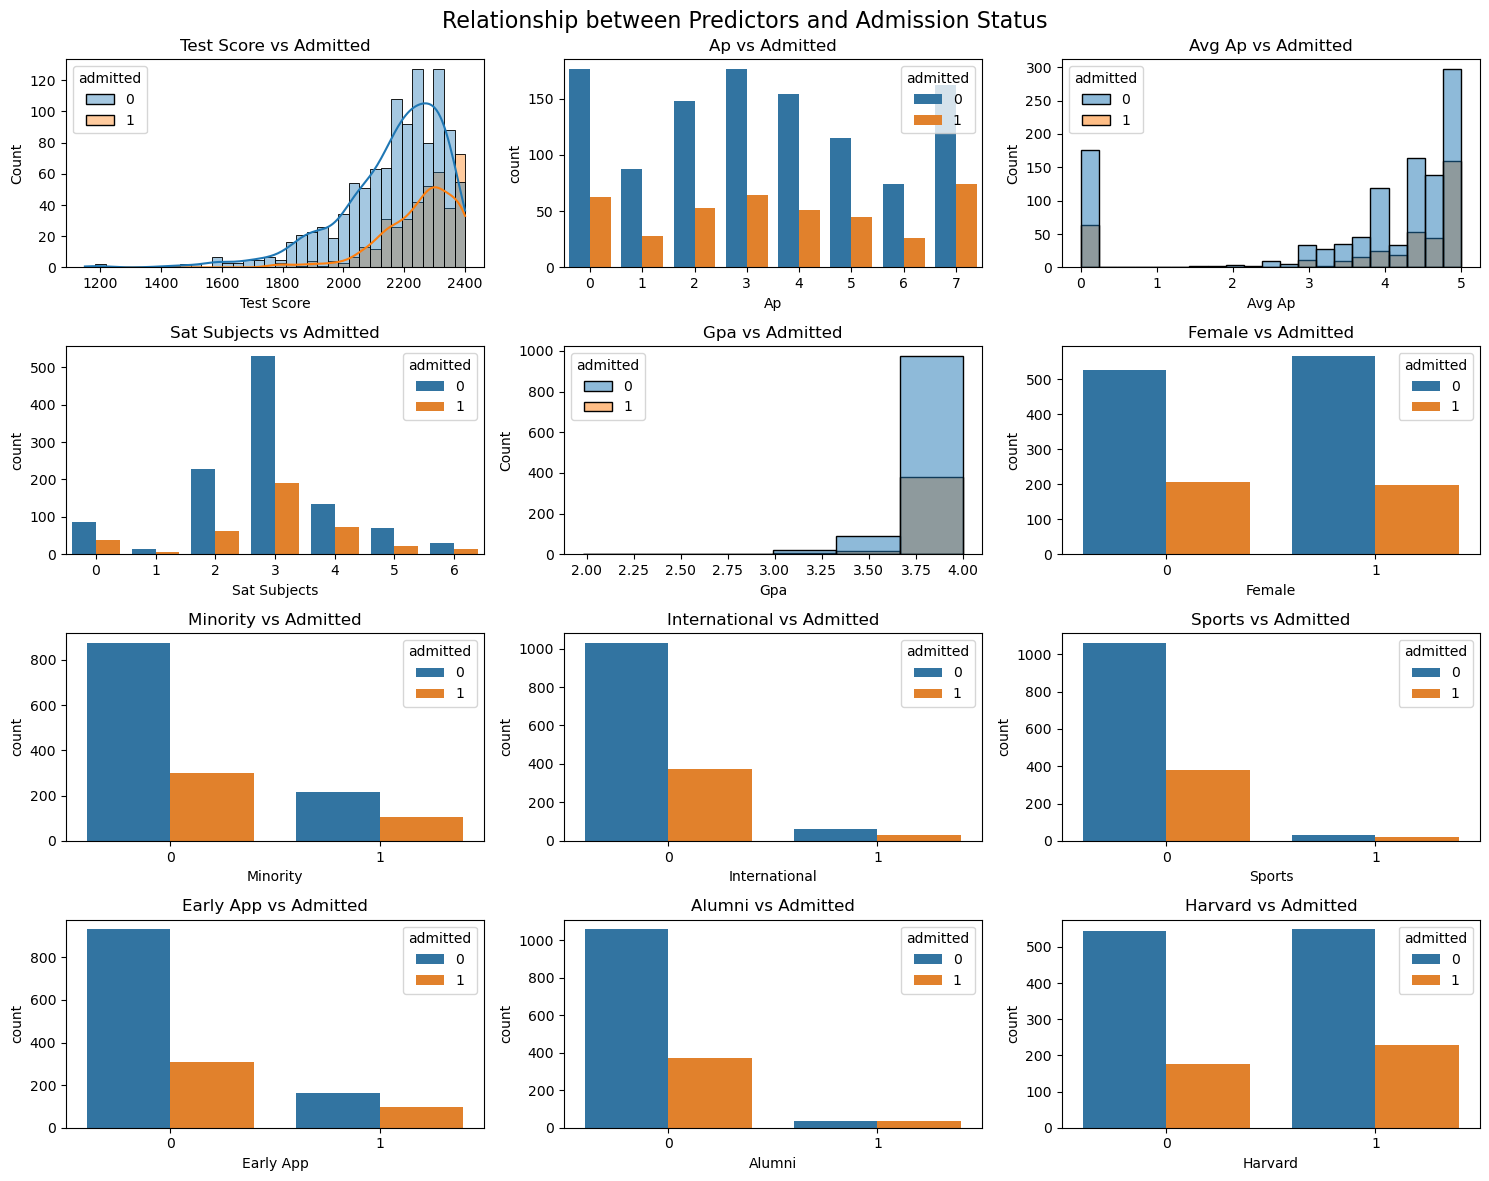

In [72]:
#v2 plot

#Step by step
# Define the predictors and their corresponding plot types
# Loop through predictors and create corresponding plots

predictors = [
    ('test_score', 'histplot', {'kde': True, 'alpha': 0.4}),
    ('ap', 'countplot', {}),
    ('avg_ap', 'histplot', {}),
    ('sat_subjects', 'countplot', {}),
    ('gpa', 'histplot', {'bins': 6}),
    ('female', 'countplot', {}),
    ('minority', 'countplot', {}),
    ('international', 'countplot', {}),
    ('sports', 'countplot', {}),
    ('early_app', 'countplot', {}),
    ('alumni', 'countplot', {}),
    ('harvard', 'countplot', {})
]


fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
fig.suptitle("Relationship between Predictors and Admission Status", fontsize=16)
axes = axes.ravel()


for ax, (predictor, plot_type, plot_kwargs) in zip(axes, predictors):
    if plot_type == 'histplot':
        sns.histplot(data=df1_train, x=predictor, hue='admitted', ax=ax, **plot_kwargs)
    elif plot_type == 'countplot':
        sns.countplot(data=df1_train, x=predictor, hue='admitted', ax=ax, **plot_kwargs)
    ax.set_title(f'{predictor.replace("_", " ").title()} vs Admitted')
    ax.set_xlabel(predictor.replace("_", " ").title())


plt.tight_layout()
plt.show()



<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.3** Based on the visuals above, which predictor seems to have the most potential for predicting `admitted`? Why do you think this it the best potential single predictor?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

## Answer : 
Based on the data, GPA, AVG_AP, and Test Score are the most promising predictors of admission. A noticeable trend emerges: as these values increase, the likelihood of admission also tends to increase.

- 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>
    
**Q1.4** Fit a logistic regression to predict `admitted` from `harvard` (call it `logit1_4`).  
- Store the coefficient and intercept in `logit1_4_coef` and `logit1_4_intercept`. Interpret these values.
- Use $\LaTeX$ to demonstrate how you can use these coefficient values to calculate the estimated probabilities of getting into each school.
- Store the results of the above calculation in `p_harvard` and `p_yale`. 
- Which school is easier to get into according to this model?

**IMPORTANT:** 
- Remember, all models in this assignment should be **unregularized** unless you are specifically asked to use regularization for a particular model.
- Use `random_state = 109` for all of your `LogisticRegression` and `LogisticRegressionCV` models in this notebook.
</div>

In [11]:
# your code here
#extract harvard out of the X_train
xhv_train1_4 = X_train[["harvard"]]

# Fit logistic regression model without regularization and Identify and report coefficients
logit1_4 = LogisticRegression(penalty=None, random_state=109).fit(xhv_train1_4,y_train)

logit1_4_coef = float(logit1_4.coef_.flatten())
logit1_4_intercept = float(logit1_4.intercept_.flatten())


# Calculate and report probabilities
#from prob formula

p_harvard = 1 / (1 + np.exp(-(logit1_4_intercept + logit1_4_coef)))
p_yale = 1 / (1 + np.exp(-logit1_4_intercept))   #because harvard = 0




/tmp/ipykernel_28708/646163474.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logit1_4_coef = float(logit1_4.coef_.flatten())
/tmp/ipykernel_28708/646163474.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logit1_4_intercept = float(logit1_4.intercept_.flatten())


In [12]:
print(
    "The coefficient for the 'logit1_4' model's only predictor 'harvard' "
    "is {:.4f} and the intercept is {:.4f}\n".format(
        logit1_4_coef, logit1_4_intercept
    )
)

print(
    "Estimated probability of acceptance for Harvard: {:.4f}"
    .format(p_harvard)
)
print(
    "Estimated probability of acceptance for Yale: {:.4f}"
    .format(p_yale)
)

The coefficient for the 'logit1_4' model's only predictor 'harvard' is 0.2512 and the intercept is -1.1280

Estimated probability of acceptance for Harvard: 0.2938
Estimated probability of acceptance for Yale: 0.2445


##### Show work in Latex 

Our logistic regression formula is: $\hat{p}= \dfrac{1}{1+e^{-z}}$ where $z = \beta_0 + \beta_1 x_1$ (i)

In this case probability that student will get admitted and harvard =1 (Harvard) and harvard = 0 (Yale)

$P(Y=1 \mid \text{harvard} = 1) = \frac{1}{1 + e^{-(-1.1280 + 0.2512 \cdot 1)}}   = 0.2938$


$P(Y=1 \mid \text{harvard} = 0) = \frac{1}{1 + e^{-(-1.1280 )}}   = 0.2445$






<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

## Answer :
Harvard is easier to get as the probability to get in harvard (P[Y=1])  is higher than (P[Y=0]  - Yale)


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [13]:
grader.check("q1.4")

q1.4 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q1.5** Create and display a [contingency table](https://en.wikipedia.org/wiki/Contingency_table) between `admitted` and `harvard`.  Use this table to calculate and confirm the coefficient estimates in the `logit1_4` model (both the intercept and slope). Show this calculation using $\LaTeX$ in a markdown cell.
    
**Hint:** The Pandas [crosstab](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html) method may be helpful here.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_Type your answer here, replacing this text._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [14]:
# Create contingency table 
train_merged = pd.concat([X_train, y_train], axis=1)
contingency_table = pd.crosstab( train_merged["admitted"], train_merged["harvard"], margins = True, margins_name = "Total")
display(contingency_table)

harvard,0,1,Total
admitted,,,
0,544,548,1092
1,176,228,404
Total,720,776,1496


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q1.6** Compare the estimated probabilities of being admitted into the schools to the overall acceptance rate (as seen [here](https://www.ivycoach.com/2022-ivy-league-admissions-statistics/)).  Why may what you've observed in this comparison be the case?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_Type your answer here, replacing this text._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

---

<a id="part2"></a>

## <div class='exercise'>Question 2: Interpretable modeling</div>

[Return to contents](#contents)

<div class='exercise-r'>

**Q2.1** 
    
- Fit a logistic regression model to predict `admitted` from `test_score` alone. Call it `logit2_1`.
- Store the learned parameters in `logit2_1_intercept` and `logit2_1_coef_test_score`. 
- Store the train accuracy and mean 10-fold cross-validation accuracy in `acc_train_logit2_1` and `acc_cv_logit2_1`.

**Note:** The coefficients and train accuracies should come from a model fit on all the training data. To calculate the mean 10-fold cross-validation accuracy, use `cross_val_score`. This should be the strategy used throughout the notebook except when using `LogisticRegressionCV` in later questions (since this model already gives you CV scores "for free"). Will will assume 10 folds whenever we cross-validate in this notebook.
</div>

In [15]:

#extract test score out of the X_train
xtscore_train2_1 = X_train['test_score'].values.reshape(-1,1)
#set k fold value
kfold = 10

#create and fit model
logit2_1 = LogisticRegression(penalty=None, random_state=109)
logit2_1.fit(xtscore_train2_1,y_train.values)

logit2_1_intercept = float(logit2_1.intercept_.flatten())
logit2_1_coef_test_score = float(logit2_1.coef_.flatten())

#calculate train accuracies and mean of 10 fold cv accuracy
acc_train_logit2_1 = logit2_1.score(xtscore_train2_1,y_train)
acc_cv_logit2_1 = cross_val_score(logit2_1,xtscore_train2_1,y_train,cv=kfold).mean()


/tmp/ipykernel_28708/2330104340.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logit2_1_intercept = float(logit2_1.intercept_.flatten())
/tmp/ipykernel_28708/2330104340.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logit2_1_coef_test_score = float(logit2_1.coef_.flatten())


In [16]:
print("The intercept and coefficient for the 'logit2_1' model are:")

print("\t{:<20}{:.4f}".format('intercept', logit2_1_intercept))
print("\t{:<20}{:.4f}".format('test_score', logit2_1_coef_test_score))

print(
    "\nThe classification accuracies for 'logit2_1' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}".format(
        acc_train_logit2_1, acc_cv_logit2_1
    )
)

The intercept and coefficient for the 'logit2_1' model are:
	intercept           -10.5474
	test_score          0.0043

The classification accuracies for 'logit2_1' are:

	Train	0.7299
	CV	0.7300


In [17]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<div class='exercise-r'>

**Q2.2**
    
- What is the estimated probability of an applicant being admitted with a `test_score` of 2250? Store this in `prob_test_2250`.
- What about if they had a perfect test score of 2400? Store this in `prob_test_2400`.
- What test score would be needed to have a 50-50 chance (i.e. 0.5 probability) of being admitted? Store this in `test_50_50`.
    
</div>

In [18]:
# your code here

test1 = 2250
test2 = 2400

prob_test_2250 =  1/(1 + np.exp(-(logit2_1_intercept + logit2_1_coef_test_score*test1)))
prob_test_2400 = 1 / (1 + np.exp(-(logit2_1_intercept + logit2_1_coef_test_score*test2)))

#In order to get 0.5 probability. ln(0.5/(1-0.5)) = 0 = intercept + coef x test_score.  Therefore testscore = - intercept/coef 
test_50_50 = -logit2_1_intercept / logit2_1_coef_test_score

In [19]:
print(
    "The estimated chances of an applicant being admitted with "
    "the following two 'test' scores:\n\n\tscore\tprobabilities"
    "\n\t2250\t{:.4f}\n\t2400\t{:.4f}\n"
    .format(prob_test_2250, prob_test_2400)
)

print(
    "The test score required to have a 50-50 chance of being "
    "admitted is approximately:\n\n\t{:.2f}"
    .format(test_50_50)
)

The estimated chances of an applicant being admitted with the following two 'test' scores:

	score	probabilities
	2250	0.3019
	2400	0.4525

The test score required to have a 50-50 chance of being admitted is approximately:

	2444.20


In [20]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<div class='exercise-r'>

**Q2.3** Fit a logistic regression model to predict `admitted` from `test_score` and `avg_ap` (call it `logit2_3`).  Store the train and mean cv accuracies calculated as before in `acc_train_logit2_3` and `acc_cv_logit2_3`. Then use the provided code to print out the coefficient estimates along with the accuracy scores.
    
</div>

In [21]:


#extract test score and avg_ap out of the X_train
x_train2_3 = X_train[["test_score","avg_ap"]].values

#set k fold value
kfold = 10

#create and fit model
logit2_3 = LogisticRegression(penalty=None, random_state=109)
logit2_3.fit(x_train2_3,y_train.values)

logit2_3_intercept = logit2_3.intercept_[0]
logit2_3_coef_test_score = logit2_3.coef_[0][0]
logit2_3_coef_avg_ap = logit2_3.coef_[0][1]


#calculate train accuracies and mean of 10 fold cv accuracy
acc_train_logit2_3 = logit2_3.score(x_train2_3,y_train)
acc_cv_logit2_3 = cross_val_score(logit2_3,x_train2_3,y_train,cv=kfold).mean()
                                

In [22]:
# Print the results of logit2_3
print("The intercept and coefficients for the 'logit2_3' model are:")
print("\t{:<20}{:.4f}".format('intercept', logit2_3_intercept))
print("\t{:<20}{:.4f}".format('test', logit2_3_coef_test_score))
print("\t{:<20}{:.4f}".format('avg_ap', logit2_3_coef_avg_ap))

print(
    "\nThe classification accuracies for 'logit2_3' are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit2_3, acc_cv_logit2_3)
)

The intercept and coefficients for the 'logit2_3' model are:
	intercept           -10.9086
	test                0.0046
	avg_ap              -0.0723

The classification accuracies for 'logit2_3' are:

	Train	0.7306
	CV	0.7299


In [23]:
grader.check("q2.3")

q2.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q2.4** Interpret the coefficient estimates for both predictors in `logit2_3` and compare the coefficient estimate for `test_score` to the one from `logit2_1`.  Why has this estimate changed?

You should inspect the relationship between `test_score` and `avg_ap` to help get a better sense for what might be happening here.

</div>

In [24]:
# Print the parameters of the last 2 models
print("The intercept and coefficient for the 'logit2_1' model are:")

print("\t{:<20}{:.4f}".format('intercept', logit2_1_intercept))
print("\t{:<20}{:.4f}".format('test_score', logit2_1_coef_test_score))

print("The intercept and coefficients for the 'logit2_3' model are:")
print("\t{:<20}{:.4f}".format('intercept', logit2_3_intercept))
print("\t{:<20}{:.4f}".format('test_score', logit2_3_coef_test_score))
print("\t{:<20}{:.4f}".format('avg_ap', logit2_3_coef_avg_ap))

The intercept and coefficient for the 'logit2_1' model are:
	intercept           -10.5474
	test_score          0.0043
The intercept and coefficients for the 'logit2_3' model are:
	intercept           -10.9086
	test_score          0.0046
	avg_ap              -0.0723


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_Type your answer here, replacing this text._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [25]:
# your code here
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q2.5** Interpret and compare the train and cv accuracies for the two models, `logit2_1` and `logit2_3`.  Explain why these accuracies are the same or different, and what about the data makes these accuracies so similar or different.

</div>

In [26]:
# Display accuracies of last 2 models
print(
    "\nThe classification accuracies for 'logit2_1' are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit2_1, acc_cv_logit2_1)
)
print(
    "\nThe classification accuracies for 'logit2_3' are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit2_3, acc_cv_logit2_3)
)


The classification accuracies for 'logit2_1' are:

	Train	0.7299
	CV	0.7300

The classification accuracies for 'logit2_3' are:

	Train	0.7306
	CV	0.7299


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_Type your answer here, replacing this text._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

---

<a id="part3"></a>

## <div class='exercise'>Question 3: Harvard and Yale?</div>

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.1**
- Fit a logistic regression model (call it `logit3_1`) to predict `admitted` from 7 predictors: `["harvard", "test_score", "ap", "avg_ap", "gpa", "female", "minority"]`.
- Store the train and mean cv accuracies in `acc_train_logit3_1` and `acc_cv_logit3_1`.
- Interpret the coefficients for the binary predictors in this model.

**Hint:**
- If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [27]:
# Print statements below assume predictors used in this order
logit3_1_predictors = ["harvard", "test_score", "ap", "avg_ap", "gpa", "female", "minority"]

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_Type your answer here, replacing this text._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [28]:
# Fit and calculate acc

kfold=10
x_train3_1 = X_train[logit3_1_predictors].values

#select max_iter=900, it was testing to start with 500 and more but it had convergence issue. 

logit3_1 = LogisticRegression(penalty=None, max_iter=900, random_state=109)
logit3_1 = logit3_1.fit(x_train3_1,y_train)
                       
acc_train_logit3_1 = logit3_1.score(x_train3_1, y_train)
acc_cv_logit3_1 = cross_val_score(logit3_1,x_train3_1,y_train,cv=kfold).mean()



In [29]:
# Grab model's intercept and coefs regardless of their shape
# (which depends on how x and y were shaped)
logit3_1_intercept = np.array(logit3_1.intercept_).flatten()[0]
logit3_1_coefs = logit3_1.coef_.flatten()

print(
    "The intercept and coefficients for the 'logit3_1' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_1_intercept
    )
)
for predictor, coef in zip(logit3_1_predictors, logit3_1_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit3_1' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit3_1, acc_cv_logit3_1)
)

The intercept and coefficients for the 'logit3_1' model are:

	intercept           -13.2643
	harvard             0.2588
	test_score          0.0052
	ap                  -0.0483
	avg_ap              -0.0307
	gpa                 0.2168
	female              -0.0492
	minority            0.7719

The classification accuracies for 'logit3_1' are:

	Train	0.7353
	CV	0.7300


In [30]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- END QUESTION -->

<div class='exercise-r'>

**Q3.2** Fit a logistic regression model (call it `logit3_2`) to predict `admitted` from 3 predictors: `["harvard", "test_score", "ap"]` along with the 2 interaction terms: `harvard` with `test_score` and `harvard` with `ap`. Name the columns for these interaction terms `harvard_test_score` and `harvard_ap`. Store the train and mean cv accuracies in `acc_train_logit3_2` and `acc_cv_logit3_2`.

</div>

In [31]:
# Print statement below assumes this order of predictors
logit3_2_predictors = ["harvard", "test_score", "ap", "harvard_test_score", "harvard_ap"]

In [32]:
#Define interaction terms
X_train["harvard_test_score"] = X_train["harvard"] * X_train["test_score"]
X_train["harvard_ap"] = X_train["harvard"] * X_train["ap"]

x_train3_2 = X_train[logit3_2_predictors].values
kfold=10

logit3_2 = LogisticRegression(penalty=None, max_iter=900, random_state=109)
logit3_2 = logit3_2.fit(x_train3_2,y_train)


acc_train_logit3_2 = logit3_2.score(x_train3_2, y_train)
acc_cv_logit3_2 = cross_val_score(logit3_2,x_train3_2,y_train,cv=kfold).mean()



In [33]:
# Print results of logit3_2
logit3_2_intercept = np.array(logit3_2.intercept_).flatten()[0]
logit3_2_coefs = logit3_2.coef_.flatten()

print(
    "The intercept and coefficients for the 'logit3_2' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_2_intercept
    )
)

for predictor, coef in zip(logit3_2_predictors, logit3_2_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))
    
print(
    "\nThe classification accuracies for 'logit3_2' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit3_2, acc_cv_logit3_2)
)

The intercept and coefficients for the 'logit3_2' model are:

	intercept           -9.8464
	harvard             -2.0378
	test_score          0.0039
	ap                  0.0048
	harvard_test_score  0.0012
	harvard_ap          -0.1045

The classification accuracies for 'logit3_2' are:

	Train	0.7360
	CV	0.7353


In [34]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.3** Simplify and write out mathematically the above model from Question 3.2 for 2 applicants:
1. someone who is applying to Harvard
2. someone who is applying to Yale (keep `test_score` and `ap` as the unknown $X$s).

The basic framework given to you below may be helpful:

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p $$
    
**NOTE:** All of your mathematical statements should be written out in your markdown cells using $\LaTeX$. Show all your steps, not just the final result.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_Type your answer here, replacing this text._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.4** Determine two classification boundaries mathematically for the model in the previous part (using the estimated coefficients): What range of values of `test_score` as a function of `ap` would an applicant be predicted to have a better than 50% chance (i.e. 0.5 probability) of being admitted into the college they applied to? 

Use the function for Harvard to answer the following question: if a student scored a perfect 2400 on `test_score`, what is the range of AP tests they should take in order to have a better than 50% chance of being admitted into Harvard?

Again, you should show your work in $\LaTeX$.
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_Type your answer here, replacing this text._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.5** Create two separate scatterplots (one for Harvard applicants and one for Yale applicants) with the predictor `test_score` on the y-axis and `ap` on the x-axis where `admitted` is color-coded and the marker denotes train vs. test data.  Then add the appropriate classification boundary from the previous question (Q3.4).  Compare these two plots (including both the location of the boundaries and where the points lie around these boundaries).

**NOTE:** As always, please be certain (a) your plot is titled, (b) everything is clearly labeled, and (c) the plot itself is formatted in a manner that makes it easy to read and interpret. It will likely take some careful work here to generate plots with data points that are clear and easy to see. You might try 'dithering' the points with a random offset so they are not all on top of one another.
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_Type your answer here, replacing this text._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [35]:
# your code here
...

In [36]:
# your code here
...

<!-- END QUESTION -->

<div class='exercise-r'>

**Q3.6** Fit a logistic regression model (call it `logit3_6`) to predict `admitted` from 4 predictors: `["harvard", "test_score", "female", "minority"]` along with 2 interaction terms: `harvard` with `female` and `harvard` with `minority`. 

 - Store the train and mean cv accuracies in `acc_train_logit3_6` and `acc_cv_logit3_6`.
 - Display the accuracy scores.
</div>

In [37]:
# Provided code in Q3.7 will assume this order of predictors
logit3_6_predictors = ["harvard",
                       "test_score",
                       "female",
                       "minority",
                       "harvard_female",
                       "harvard_minority"
                      ]

In [38]:


#Define interaction terms
X_train["harvard_female"] = X_train["harvard"] * X_train["female"]
X_train["harvard_minority"] = X_train["harvard"] * X_train["minority"]

x_train3_6 = X_train[logit3_6_predictors].values
kfold=10

logit3_6 = LogisticRegression(penalty=None, max_iter=900, random_state=109)
logit3_6 = logit3_6.fit(x_train3_6,y_train)


acc_train_logit3_6 = logit3_6.score(x_train3_6, y_train)
acc_cv_logit3_6 = cross_val_score(logit3_6,x_train3_6,y_train,cv=kfold).mean()




In [39]:
print(
    "\nThe classification accuracies for 'logit3_6' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit3_6, acc_cv_logit3_6)
)


The classification accuracies for 'logit3_6' are:

	Train	0.7353
	CV	0.7279


In [40]:
grader.check("q3.6")

q3.6 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.7** Interpret the coefficients associated with `female` and `minority` (the two main effects AND the two interaction terms).
    
</div>

In [41]:
# Display results
logit3_6_intercept = np.array(logit3_6.intercept_).flatten()[0]
logit3_6_coefs = logit3_6.coef_.flatten()

print(
    "The intercept and coefficients for the 'logit3_6' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_6_intercept
    )
)

for predictor, coef in zip(logit3_6_predictors, logit3_6_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))

The intercept and coefficients for the 'logit3_6' model are:

	intercept           -12.0594
	harvard             0.2770
	test_score          0.0049
	female              -0.1550
	minority            1.0954
	harvard_female      0.2359
	harvard_minority    -0.6199


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_Type your answer here, replacing this text._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.8** Based on this model, how does it appear that Harvard and Yale compare in admitting women and minorities?  Given what we've seen in our previous analysis, what might be some reasons we have to doubt the interpretation of the model's coefficients as reflecting the truth?

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_Type your answer here, replacing this text._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

---

<a id="part4"></a>

## <div class='exercise'>Question 4: Building predictive models for admitted</div>

[Return to contents](#contents)

<div class='exercise-r'>

**Q4.1** You were instructed to NOT scale predictors in the prior sections above. The primary reason for this was to focus instead on the interpretability of our logistic regression coefficients. However, as we're sure you noticed, the numeric scale among our different predictors varies greatly (i.e. `test_score` values are in the 1,000's while others are much, much smaller). In practice, we might want to put our predictors all on a similar scale, particularly for regularized regression and/or distance-based algorithms such as $k$-NN classification. 

1. Explain why scaling under these circumstances might be important.
2. Define a list of all non-binary predictors from the original set of 12 predictors, calling it `non_binary_predictors`.
3. Apply standardized scaling to all of these **non-binary** predictors. **For the sake of consistency, fit your scaler on just the training data. Then use it to transform both train and test.**

**IMPORTANT:** These scaled predictors should be used instead of the original unscaled versions of the predictors for the remainder of this problem set. Tests from this point on assume that `X_train` and `X_test` have been standardized with the approach outlined above. 

</div>

In [42]:
# Identify a nonbinary
non_binary_predictors = ['test_score', 'ap', 'avg_ap', 'sat_subjects', 'gpa']

# apply standard scaler to non-binary predictors
scaler = StandardScaler()
X_train[non_binary_predictors] = scaler.fit_transform(X_train[non_binary_predictors])
X_test[non_binary_predictors] = scaler.transform(X_test[non_binary_predictors])


In [43]:
# preview summary stats after standardizing
X_train.describe()

,test_score,ap,avg_ap,sat_subjects,gpa,female,minority,international,sports,early_app,alumni,harvard,harvard_test_score,harvard_ap,harvard_female,harvard_minority
count,1.496e+03,1.496e+03,1.496e+03,1.496e+03,1.496e+03,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000
mean,5.343e-16,3.800e-17,1.639e-16,1.615e-16,-4.180e-16,0.511,0.215,0.061,0.035,0.172,0.046,0.519,1133.842,1.780,0.255,0.118
std,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,0.500,0.411,0.239,0.185,0.378,0.210,0.500,1099.344,2.402,0.436,0.323
min,-6.125e+00,-1.470e+00,-2.159e+00,-2.262e+00,-9.703e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,-4.540e-01,-6.091e-01,-1.203e-01,-6.917e-01,-2.008e-01,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1.958e-01,-1.787e-01,4.205e-01,9.342e-02,3.612e-01,1.000,0.000,0.000,0.000,0.000,0.000,1.000,1825.000,0.000,0.000,0.000
75%,7.275e-01,6.822e-01,6.909e-01,9.342e-02,6.167e-01,1.000,0.000,0.000,0.000,0.000,0.000,1.000,2230.000,3.000,1.000,0.000
max,1.259e+00,1.543e+00,7.533e-01,2.449e+00,6.167e-01,1.000,1.000,1.000,1.000,1.000,1.000,1.000,2400.000,7.000,1.000,1.000


In [44]:
grader.check("q4.1")

q4.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q4.2** Fit a well-tuned $k$-NN classification model with main effects of all 12 predictors in it (call it `knn_model`).  Use `ks = range(1, 50, 2)` and 10-fold cross-validation with classification accuracy as the scoring metric. Plot, on a single set of axes, your resulting cross-validation mean training and mean validation scores at each value $k$. Then, store your chosen $k$ in `best_k`, the accuracy on the best model when refit on all the training data in `knn_train_acc`, and the mean 10-fold CV accuracy of the best model in `knn_cv_acc`.
    
</div>

In [45]:
ks = range(1, 50, 2)
train_score = []
val_score = []
kfold=10
#using x_predictors from the beginning to get 12 predictors

for k in ks:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    cv_score = cross_validate(knn_model, X_train[x_predictors], y_train, cv=kfold, scoring='accuracy', return_train_score=True)
    train_score.append(np.mean(cv_score['train_score']))
    val_score.append(np.mean(cv_score['test_score']))
    
#Get the best k with highest val score and fit KNN using best_k
best_k = ks[np.argmax(val_score)]

best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train[x_predictors], y_train)

knn_train_acc = best_knn.score(X_train[x_predictors], y_train)
knn_cv_acc =  np.mean(cross_validate(best_knn, X_train[x_predictors], y_train, cv=kfold, scoring='accuracy')['test_score'])                        
                           



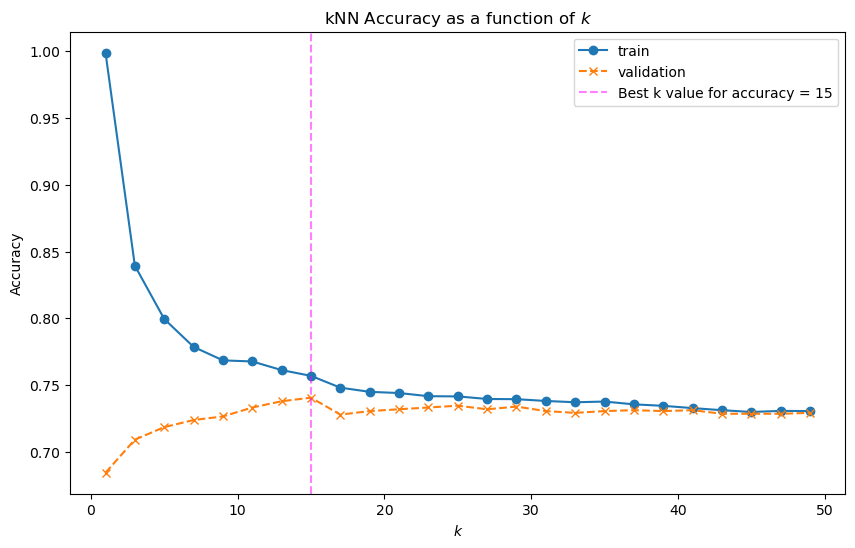

In [46]:
# Plot cross-validation results

plt.figure(figsize=(10, 6))
plt.plot(ks, train_score, label='train',linestyle='-', marker='o')
plt.plot(ks, val_score, label='validation' ,linestyle='--', marker='x')
plt.axvline(best_k, color='magenta', alpha=0.5, linestyle='--', label= 'Best k value for accuracy = {}'.format(best_k))

plt.xlabel(r'$k$')
plt.ylabel('Accuracy')
plt.title('kNN Accuracy as a function of $k$')
plt.legend();


In [47]:
print(
    "The classification accuracies for 'knn_model' where k={} "
    "are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(
        best_k, knn_train_acc, knn_cv_acc
    )
)
# create dict for storing test scores for each Q4 model
q4_cv_scores = {"knn_model": knn_cv_acc}

The classification accuracies for 'knn_model' where k=15 are:

	Train	0.7574
	CV	0.7407


<!-- END QUESTION -->

<div class='exercise-r'>

**Q4.3** Fit the full logistic regression model (without penalty) with main effects of all 12 predictors in it (call it `logit_full`). Store the train mean cv accuracy in `logit_full_train_acc` and `logit_full_cv_acc`.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [48]:
# The code that prints your results assumes
# predictors were given to the model in this order
predictor_list = [
    "test_score", "ap", "avg_ap", "sat_subjects",
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]

In [49]:
X_train[predictor_list].head()

,test_score,ap,avg_ap,sat_subjects,gpa,female,minority,international,sports,harvard,early_app,alumni
192,0.727,1.543,0.753,1.664,0.514,0,0,0,0,1,0,0
652,-1.045,-0.179,0.365,0.093,-0.661,1,1,0,0,1,0,0
593,-0.631,0.682,0.287,-0.692,-0.150,0,0,0,0,1,0,0
331,0.373,-1.470,-2.159,-0.692,0.617,0,0,0,0,1,0,0
1117,0.255,0.252,0.171,1.664,0.412,1,0,0,0,0,1,0


In [50]:

#create x_train_full to train the full logistic reg.


x_train_full = X_train[predictor_list]
kfold=10

logit_full = LogisticRegression(penalty=None, max_iter=900, random_state=109)
logit_full = logit_full.fit(x_train_full,y_train)

logit_full_train_acc = logit_full.score(x_train_full, y_train)
logit_full_cv_acc = cross_val_score(logit_full,x_train_full,y_train,cv=kfold).mean()


In [51]:
# display your results
print(
    "The intercept and coefficients for the 'logit_full' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(logit_full.intercept_).flatten()[0]
    )
)

for predictor, coef in zip(predictor_list, logit_full.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit_full' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(logit_full_train_acc, logit_full_cv_acc)
)

# store test score to dict for later use
q4_cv_scores["logit_full"] = logit_full_cv_acc

The intercept and coefficients for the 'logit_full' model are:

	intercept           -1.7415
	test_score          0.8893
	ap                  -0.1284
	avg_ap              0.0008
	sat_subjects        -0.0976
	gpa                 0.0697
	female              -0.0175
	minority            0.8088
	international       0.3067
	sports              1.0388
	harvard             0.3949
	early_app           0.6029
	alumni              0.8664

The classification accuracies for 'logit_full' are:

	Train	0.7447
	CV	0.7373


In [52]:
grader.check("q4.3")

q4.3 results: All test cases passed!

<div class='exercise-r'>

**Q4.4** Fit a well-tuned Lasso-like logistic regression model from all 12 predictors in it (call it `logit_lasso`). Use `Cs = np.logspace(-2, 2, 50)` and 10-fold cross-validation. Store the train and mean cross-validation accuracies in `logit_lasso_train_acc` and `logit_lasso_cv_acc`. For tuning a regularized logistic regression model, you should use `LogisticRegressionCV`. But again, to insure reproducability here, you should set `random_state=109`. 

**Hint:**
- The default solver for SKLearn's logistic regression, 'lbfgs', is not compatible with LASSO regularization, so you will need to use a different solver here. See the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) for guidance.

</div>

In [53]:

# use x_train_full from previous step to train Lasso like Logistic reg.
#from sklearn doc, Specify penalty = 'l1' for Lasso and solver determine the algorithm
#In this case,I choose solver = liblinear as it is possible to support 'l1' and 'l2' 


Cs = np.logspace(-2, 2, 50)
kfold=10

logit_lasso = LogisticRegressionCV(
        Cs=Cs,
        penalty = 'l1',
        cv=kfold,
        scoring = 'accuracy',
        random_state = 109,
        solver = 'liblinear',
        n_jobs = -1)

#fit model
logit_lasso.fit(x_train_full, y_train)

# Get the best C value and CV accuracy
best_C = logit_lasso.C_[0]  # [0] for binary classification
logit_lasso_cv_acc = logit_lasso.scores_[1].mean(axis=0).max()
logit_lasso_train_acc = logit_lasso.score(x_train_full, y_train)


In [55]:

# Display your results
print(
    "The intercept and coefficients for the 'logit_lasso' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(logit_lasso.intercept_).flatten()[0]
    )
)

# Again, this code assumes predictors were given to the model
# in the order defined in `predictor_list`
for predictor, coef in zip(predictor_list, logit_lasso.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit_lasso' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(logit_lasso_train_acc, logit_lasso_cv_acc)
)

# store cv score to dict for later use
q4_cv_scores["logit_lasso"] = logit_lasso_cv_acc

The intercept and coefficients for the 'logit_lasso' model are:

	intercept           -1.5207
	test_score          0.8187
	ap                  -0.0967
	avg_ap              -0.0240
	sat_subjects        -0.0689
	gpa                 0.0283
	female              -0.0029
	minority            0.6527
	international       0.0000
	sports              0.5988
	harvard             0.2628
	early_app           0.4534
	alumni              0.6012

The classification accuracies for 'logit_lasso' are:

	Train	0.7420
	CV	0.7380


In [57]:
grader.check("q4.4")

q4.4 results: All test cases passed!

<div class='exercise-r'>

**4.5** Which predictors were deemed important in `logit_lasso`?  Which were deemed unimportant? Here we assume that any predictors with zero-valued Lasso coefficients "unimportant". Store your results in `predictors_important` and `predictors_not_important`.
 
</div>

In [59]:
#Any coef which is not equal to zero is important. From Q4.4 output, all of the coef are not equal to zero. So all of them are important!
predictors_important=[]
predictors_not_important = []

logit_lasso_coef = logit_lasso.coef_.flatten()
print(logit_lasso_coef)

for i in range(len(predictor_list)):
    if logit_lasso_coef[i] != 0:
        predictors_important.append(predictor_list[i])
    else:
        predictors_not_important.append(predictor_list[i])

print(len(predictors_important))
print(len(predictors_not_important))


[ 0.81867251 -0.09674788 -0.02401619 -0.0688711   0.02828791 -0.00290954
  0.65265595  0.          0.59884629  0.26276965  0.45341227  0.601204  ]
11
1


In [60]:
# display results
print(
    "The following predictors were deemed important by "
    "'logit_lasso' (i.e. coef != 0):\n\n\t{}\n\n\n"
    "While, the remaining were deemed unimportant (i.e. "
    "coef == 0):\n\n\t{}"
    .format(
        predictors_important,
        predictors_not_important,
    )
)

The following predictors were deemed important by 'logit_lasso' (i.e. coef != 0):

	['test_score', 'ap', 'avg_ap', 'sat_subjects', 'gpa', 'female', 'minority', 'sports', 'harvard', 'early_app', 'alumni']


While, the remaining were deemed unimportant (i.e. coef == 0):

	['international']


In [61]:
grader.check("q4.5")

q4.5 results: All test cases passed!

<div class='exercise-r'>

**Q4.6** Fit a well-tuned Lasso-like logistic regression model with all important predictors from `logit_lasso` and all the unique 2-way interactions between them (call it `lasso_interact`).  Again use `Cs = np.logspace(-2, 2, 50)`,  and 10-fold cross-validation with classification accuracy as the scoring metric. Record the accuracy on train and test for this model in `lasso_interact_train_acc` and `lasso_interact_test_acc`.

</div>

In [68]:
# your code here
#Create new features including 2-ways interaction term and important feature from previous steps.

x_interact = pd.DataFrame()

for i in range(len(predictors_important)):
    for j in range(i+1,len(predictors_important)):
        feature1 = predictors_important[i]
        feature2 = predictors_important[j]
        interact_name = f"{feature1}_{feature2}"
        x_interact[interact_name] = x_train_full[feature1] * x_train_full[feature2]


x_lasso_interact = pd.concat([x_train_full[predictors_important],x_interact],axis=1)
x_lasso_interact.reset_index(drop=True)
x_lasso_interact.head()


,test_score,ap,avg_ap,sat_subjects,gpa,female,minority,sports,harvard,early_app,alumni,test_score_ap,test_score_avg_ap,test_score_sat_subjects,test_score_gpa,test_score_female,test_score_minority,test_score_sports,test_score_harvard,test_score_early_app,test_score_alumni,ap_avg_ap,ap_sat_subjects,ap_gpa,ap_female,...,sat_subjects_sports,sat_subjects_harvard,sat_subjects_early_app,sat_subjects_alumni,gpa_female,gpa_minority,gpa_sports,gpa_harvard,gpa_early_app,gpa_alumni,female_minority,female_sports,female_harvard,female_early_app,female_alumni,minority_sports,minority_harvard,minority_early_app,minority_alumni,sports_harvard,sports_early_app,sports_alumni,harvard_early_app,harvard_alumni,early_app_alumni
192,0.727,1.543,0.753,1.664,0.514,0,0,0,1,0,0,1.122,0.548,1.210,0.374,0.000,0.000,0.0,0.727,0.000,0.0,1.162,2.567,0.794,0.000,...,0.0,1.664,0.000,0.0,0.000,0.000,0.0,0.514,0.000,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
652,-1.045,-0.179,0.365,0.093,-0.661,1,1,0,1,0,0,0.187,-0.381,-0.098,0.690,-1.045,-1.045,-0.0,-1.045,-0.000,-0.0,-0.065,-0.017,0.118,-0.179,...,0.0,0.093,0.000,0.0,-0.661,-0.661,-0.0,-0.661,-0.000,-0.0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
593,-0.631,0.682,0.287,-0.692,-0.150,0,0,0,1,0,0,-0.431,-0.181,0.437,0.094,-0.000,-0.000,-0.0,-0.631,-0.000,-0.0,0.196,-0.472,-0.102,0.000,...,-0.0,-0.692,-0.000,-0.0,-0.000,-0.000,-0.0,-0.150,-0.000,-0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
331,0.373,-1.470,-2.159,-0.692,0.617,0,0,0,1,0,0,-0.548,-0.805,-0.258,0.230,0.000,0.000,0.0,0.373,0.000,0.0,3.173,1.017,-0.906,-0.000,...,-0.0,-0.692,-0.000,-0.0,0.000,0.000,0.0,0.617,0.000,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1117,0.255,0.252,0.171,1.664,0.412,1,0,0,0,1,0,0.064,0.044,0.424,0.105,0.255,0.000,0.0,0.000,0.255,0.0,0.043,0.419,0.104,0.252,...,0.0,0.000,1.664,0.0,0.412,0.000,0.0,0.000,0.412,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [78]:

Cs = np.logspace(-2, 2, 50)
kfold=10

lasso_interact = LogisticRegressionCV(
        Cs=Cs,
        penalty = 'l1',
        cv=kfold,
        scoring = 'accuracy',
        random_state = 109,
        solver = 'liblinear',
        n_jobs = -1)

#fit model
lasso_interact.fit(x_lasso_interact, y_train)

# Get the best C value and CV accuracy
best_C = lasso_interact.C_[0]  # [0] for binary classification
lasso_interact_cv_acc = lasso_interact.scores_[1].mean(axis=0).max()
lasso_interact_train_acc = lasso_interact.score(x_lasso_interact, y_train)

#Intercept and coef output
print(
    "Intercept and coefficients for 'logit_lasso_interact' are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(lasso_interact.intercept_).flatten()[0]
    )
)

for predictor, coef in zip(x_lasso_interact.columns,
                           lasso_interact.coef_[0]):
    print("\t{:<20}{:.4f}".format(predictor, coef))


Intercept and coefficients for 'logit_lasso_interact' are:

	intercept           -1.5921
	test_score          0.7175
	ap                  0.0000
	avg_ap              -0.2107
	sat_subjects        0.0000
	gpa                 0.0827
	female              -0.1347
	minority            0.9686
	sports              0.8106
	harvard             0.2748
	early_app           0.5005
	alumni              0.7005
	test_score_ap       0.0000
	test_score_avg_ap   0.0079
	test_score_sat_subjects-0.0842
	test_score_gpa      0.1266
	test_score_female   0.0706
	test_score_minority 0.0000
	test_score_sports   -0.1073
	test_score_harvard  0.1786
	test_score_early_app-0.0546
	test_score_alumni   0.3520
	ap_avg_ap           0.0151
	ap_sat_subjects     -0.0819
	ap_gpa              0.0615
	ap_female           0.0000
	ap_minority         0.2003
	ap_sports           0.0000
	ap_harvard          -0.3656
	ap_early_app        -0.0091
	ap_alumni           0.4184
	avg_ap_sat_subjects 0.0549
	avg_ap_gpa          -0.1452
	av

In [79]:
print(
    "\nThe classification accuracies for 'logit_lasso_interact' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}\n"
    .format(lasso_interact_train_acc, lasso_interact_cv_acc)
)

# store test score to dict for later use
q4_cv_scores["lasso_interact"] = lasso_interact_cv_acc


The classification accuracies for 'logit_lasso_interact' are:

	Train	0.7547
	CV	0.7386



<div class='exercise-r'>

**Q4.7** How many of the predictors in our `logit_lasso_interact` model were deemed important and unimportant? Store these numbers in `num_important_coefs` and `num_unimportant_coefs`. 
    
</div>

In [81]:
#counting important and unimportant coef

num_important_coefs=0
num_unimportant_coefs = 0

lasso_interact_coef = lasso_interact.coef_.flatten()

for coef_i in lasso_interact.coef_.flatten():
    if abs(coef_i) != 0:
        num_important_coefs = num_important_coefs+1
    else:
        num_unimportant_coefs = num_unimportant_coefs + 1



In [82]:
print(
    "Of the {} predictors used in our 'logit_lasso_interact' model:"
    "\n\n\t{} predictors were deemed 'important' by our model"
    "\n\t{} predictors were deemed 'unimportant' with 0-valued "
    "coefficients".format(
        num_important_coefs + num_unimportant_coefs,
        num_important_coefs,
        num_unimportant_coefs
    )
)

Of the 66 predictors used in our 'logit_lasso_interact' model:

	44 predictors were deemed 'important' by our model
	22 predictors were deemed 'unimportant' with 0-valued coefficients


In [83]:
grader.check("q4.7")

q4.7 results: All test cases passed!

---

<a id="part5"></a>

## <div class='exercise'>Question 5: Evaluating results</div>

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q5.1** Which of the 4 models in Question 4 performs the best based on cross-validation accuracy?  Which performs the worst? Based on these accuracies, how do these models perform compared to your baseline "naive" model's performance on the training data back in Question 1.1? What does this comparison to the "naive" model tell us?
    
</div>

In [84]:
# your code here
print("The CV accuracies for the 4 models in Q4 are:\n")
for key, value in q4_cv_scores.items():
    print("\t{:<25}{:.4f}".format(key, value))
print(
    "\nThe  accuracy for our original baseline \"naive\" "
    "model was {:.4f}".format(naive_train_acc)
)

The CV accuracies for the 4 models in Q4 are:

	knn_model                0.7407
	logit_full               0.7373
	logit_lasso              0.7380
	lasso_interact           0.7386

The  accuracy for our original baseline "naive" model was 0.7299


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

### Answer :

The model with the highest cross-validation (CV) accuracy is the k-nearest neighbors (KNN) model, achieving a score of 0.7407. The logistic regression model with all predictors (logit_full) has the lowest CV accuracy at 0.7373. Notably, all models outperform the baseline "naive" model, which has an accuracy of 0.7299.

The "naive" model, implemented using a DummyClassifier, predicts outcomes based on choosing the most frequent class observed in the training data. This model serves as a benchmark; if a more complex model performs worse than the naive model, it suggests potential issues with that model. By comparing advanced models to this baseline, we can determine if they are effectively learning meaningful patterns or merely capturing noise in the data





<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q5.2** Draw an ROC curve for each of the four models on a single plot.  How do these ROC curves compare?  Do the ROC curves support that the best model identified in Question 5.1 is better than the worst model identified in 5.1?  How do you know?

**Hint:** Use `cross_val_predict` with `method='predict_proba` to get the probability predictions required to construct the ROC curves.
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_Type your answer here, replacing this text._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [87]:

# Plot ROC Curves on four models
best_knn_prob = best_knn.predict_proba(X_test[predictor_list])[:,1]
fpr_knn, tpr_knn, threshholds_knn = roc_curve(y_test, best_knn_prob)
auc_knn = np.round(roc_auc_score(y_test, best_knn_prob),3)

logit_full_prob = logit_full.predict_proba(X_test4_3)[:,1]
fpr_logit_full, tpr_logit_full, threshholds_logit_full = roc_curve(y_test, logit_full_prob)
auc_logit_full = np.round(roc_auc_score(y_test, logit_full_prob),3)


logit_lasso_prob = logit_lasso.predict_proba(X_test[predictor_list])[:,1]
fpr_logit_lasso, tpr_logit_lasso, threshholds_logit_lasso = roc_curve(y_test, logit_lasso_prob)
auc_logit_lasso = np.round(roc_auc_score(y_test, logit_lasso_prob),3)


lasso_interact_prob = lasso_interact.predict_proba(X_test_lasso_interact_df)[:,1]
fpr_lasso_interact, tpr_lasso_interact, threshholds_lasso_interact = roc_curve(y_test, lasso_interact_prob)
auc_lasso_interact = np.round(roc_auc_score(y_test, lasso_interact_prob),3)



In [89]:
# your code here


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.3** Calculate the AUC for all 4 models and store these in `auc_list`. **The order of AUCs in the list should match the order of the model as they appear in `q4_cv_scores`.**
    
Do the rankings of these 4 models based on AUC match those for classification accuracy?  Why do you think this is the case?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_Type your answer here, replacing this text._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [ ]:
# your code here
# calculate each model's AUC using its ROC fpr and tpr
auc_list = ...
    
...

In [ ]:
print(
    "The CV accuracies & CV AUC scores for the 4 models in Q4 are:"
    "\n\n\t\t\t\tAccuracy\tAUC"
)
for (key, value), auc_value in zip(q4_cv_scores.items(), auc_list):
    print("\t{:<24}{:.4f}\t\t{:.4f}".format(key, value, auc_value))

In [ ]:
grader.check("q5.3")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q5.4** Select your preferred model based on the cross-validation accuracy and AUC. For this 'final model', display the accuracy and AUC scores on the **test data**. Compare these to the accuracy and AUC score of the naive model from 1.1 when predicting on the test data. Would you offer your final model as a publicly available tool for college applicants to use to determine their chances of getting into Harvard and/or Yale? Why or why not? What might be some consequences of the deployment of the model into the real world?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_Type your answer here, replacing this text._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [ ]:
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<a id="part6"></a>

## <div class='exercise'>Question 6: BONUS!</div>

[Return to contents](#contents)

<div class='exercise-r'>

**Q6 (optional)** Incorporate what you've learned from the PCA and/or Missingness sections of the course to create a new, improved classification model. You could focus on improving predictive performance, inference, interpretability, or all of the above! 

Be sure to also describe your approach and analyze your results.

While this section is optional, we highly encourge you to experiment (and not just for the sake of the potential bonus points 😉).

**Note:** Though you should report the test performance of this new, "bonus" model, selecting the bonus model over the 'final model' from Q5.4 would have to be justified based on cross-validation performance, *not* test performance! 
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_Type your answer here, replacing this text._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [ ]:
# your code here

<!-- END QUESTION -->

<div class="alert alert-info" style="color: #4a4a4a; background-color: #fbe8ff; border-color: #eed4db; border-width: 1px; border-radius: 3px; padding: 10px;">

**Wrap-up**

* Please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation. This is also a good place to ask any remaining questions you may have.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

</div>

In [ ]:
hours_spent_on_hw = ...

In [ ]:
grader.check("wrapup")

In [ ]:
notebook_end = time.time()
print(f"It took {(notebook_end - notebook_start)/60:.2f} minutes for this notebook to run")

🌈 **This concludes HW5. Thank you!**

[Return to contents](#contents)